# Bayesian Data Analysis 2019 - Data Analysis Project Report

## Analysis problem

The aim of this project is to analyse variation from month to month in public transportation. The variations from rush hours to late night are obvious to all of us using public transport. The decision makers are not necessarily analysing these changes between different months, even though it could prove valuable for example, in the maintenance, training and testing of equipment or operators. Therefore we want to look at the monthly variation from multiple years of data.

Furthermore, we want to analyse differences and correlations in the rush hours and quieter hours from one month to the other. For example, Holidays during December might have less difference from time to time, since there are less working days.

## Loaded packages

Below are the loaded packages that are used in the project. Remember to make sure that all the packages are installed into the system (for example, pystan).

In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import pystan
import datetime
import arviz as az

## Description of data

The data set used is provided by UCI Machine Learning Repository.

The data set is called "Metro Interstate Traffic Volume Data Set", and it is described by the provider as follows: "Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weather features and holidays included for impacts on traffic volume."

Below we load the data from our csv file. This file is accessible at https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume 

The part of the data we are the most interested in are the date_time and traffic_volume. From date_time we can easily capture the months and hours of data and from traffic volume, we get the number of passengers passing the specific station starting the mentioned hour. We are going to analyse the working days in order to avoid biases in the distributions and to focus on the business side of operating the transportation.

In [2]:
# load data

df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")

df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


Let's first look at the data in traffic volume. Below, we can see a histogram of passengers each hour. There are clearly a lot of really slow hours. Then, around 3000 and 4500 there are a couple of spikes. These spikes could be rush hours, last trains going through the station or similar, but we are not sure at this point. There do not seem to be clear anomalies, since the data is well spread out and the scale seems to fit automatically quite well, i.e. there are no singular values of 10000 or more.

Text(0.5, 1.0, 'Traffic volume')

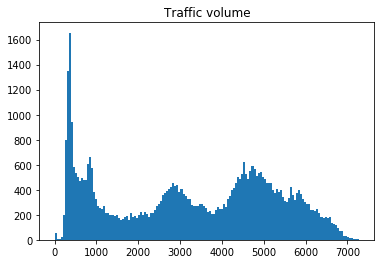

In [3]:
plt.hist(df['traffic_volume'], bins=150)
plt.title("Traffic volume")

Next, we will edit our data in order to gain better access into the hourly and monthly attributes.

In [4]:
# convert date_time-field into datetime format & add index
df_with_dates = df
df_with_dates['date_time'] = pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')
df_with_dates = df_with_dates.set_index('date_time')
df_with_dates['weekday'] = df_with_dates.index.dayofweek
df_with_dates['month'] = df_with_dates.index.month
df_with_dates.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,weekday,month
date_time,,,,,,,,,,
2012-10-02 09:00:00,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545,1,10
2012-10-02 10:00:00,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516,1,10
2012-10-02 11:00:00,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767,1,10
2012-10-02 12:00:00,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026,1,10
2012-10-02 13:00:00,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918,1,10


Text(0.5, 1.0, 'Traffic at 12:00')

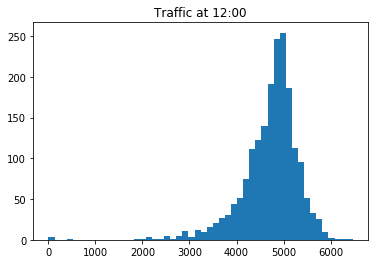

In [5]:
def traffic_at_time(time, dataframe):
    return dataframe.at_time('{}:00'.format(time))['traffic_volume']

# inefficient, but makes testing easier
traffic_by_time = [traffic_at_time(time, df_with_dates) for time in range(24)]

# make all sublists same size
def trim(arr):
    min_n = min([len(arr[n]) for n in range(len(arr))])
    return [arr[n][:min_n] for n in range(len(arr))]

traffic_by_time = trim(traffic_by_time)

# e.g. traffic volume at 12

plt.hist(traffic_by_time[12], bins=50)
plt.title("Traffic at 12:00")

Below, we have created an easily accessible dataframe on the traffic volumes of a certain month. The histogram below is at 8 o'clock in the weekday mornings in January. 

(array([ 1.,  0.,  0.,  1.,  1.,  0.,  1.,  3.,  4.,  8.,  9., 23., 21.,
        23.,  6.]),
 array([1996. , 2299.2, 2602.4, 2905.6, 3208.8, 3512. , 3815.2, 4118.4,
        4421.6, 4724.8, 5028. , 5331.2, 5634.4, 5937.6, 6240.8, 6544. ]),
 <a list of 15 Patch objects>)

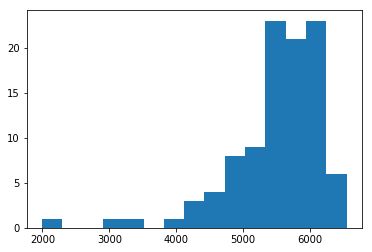

In [6]:
# holds traffic during weekdays at 8
traffic_by_month = [traffic_at_time(8, df_with_dates[(df_with_dates['month'] == month) & (df_with_dates['weekday'] < 5)]) 
                    for month in range(1,13)]

traffic_by_month = trim(traffic_by_month)
# traffic in january during weekdays at 8
plt.hist(traffic_by_month[1], bins=15)

### Further analysis on data

In this part we have further analysed the extra data in the dataset. We also discuss some outliers and missing data. These **insights might help us form our distributions later on in the project and analyse the results**. Thus, we see it fit to look at the data even though it is not used. Feel free to skip this part.

In [7]:
#df.describe()

There are many labelled data columns in our data. Below we can see the holiday, weather main and weather description labels.

In [8]:
#df['holiday'].value_counts()

In [9]:
#df['weather_main'].value_counts()

In [10]:
#df['weather_description'].value_counts()

From the temperature data we can see that there are clear outliers. The x-axel is scaled from 0 to 300 even though there are barely any values below 250. When we dig deeper below the 250 values, we can see there are a couple of really low values. 

In [11]:
#plt.hist(df['temp'], bins=50)
#plt.title("Temperature")

In [12]:
#df_low_temp = df[df['temp'] < 250]
#plt.hist(df_low_temp['temp'], bins=50)
#plt.title("Low temperatures")

In [13]:
#df[df['temp'] == 0]

When we look at these zero Kelvin temperatures, we can see that the observations seem otherwise correct. The sky is clear, there is no rain or snow, and there are some small amounts of traffic during that time. Thus, we suggest that these datapoints only lack the temperature data and can still be used. We would fix the points by taking the average temperature during similar times (Jan-Feb nights).

Next off is the rain. We can see again that there are some outliers. When we take the description of our data, we see there is a datapoint with around 9831 mm of rain. Otherwise, the data seems reasonable. There are some 50mm rain points, but this is still realistic within one hour of really heavy rain. We would set the 9831mm datapoint to an average of our very heavy rain weather descriptions.

In [14]:
#plt.hist(df['rain_1h'], bins=50)
#plt.title("Rain")

In [15]:
#df[df['weather_description'] == 'very heavy rain']

In [16]:
#df_rain = df[df['rain_1h'] < 9831]
#plt.hist(df_rain['rain_1h'], bins=50)
#plt.title("Corrected rain")

With snow and clouds, the data seems to be correct. There are a lot of datapoints with 0 snow, but there are also a lot of points where there are similar looking numbers of snow. With clouds, the data is quite dispersed.

In [17]:
#plt.hist(df['snow_1h'], bins=150)
#plt.title("Snow")

In [18]:
#plt.hist(df['clouds_all'], bins=50)
#plt.title("Clouds")

## Description of models

Like discussed in the analysis problem, there are different distributions from one hour to the next. There might even be multiple peaks in the distributions of an hourly data. We chose to use hierarchical and pooled models for our data analysis.

Text(0.5, 1.0, 'Traffic at 8:00')

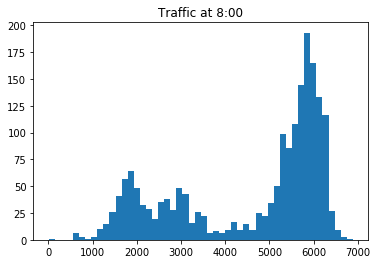

In [19]:
plt.hist(traffic_by_time[8], bins=50)
plt.title("Traffic at 8:00")

Text(0.5, 1.0, 'Traffic at 19:00')

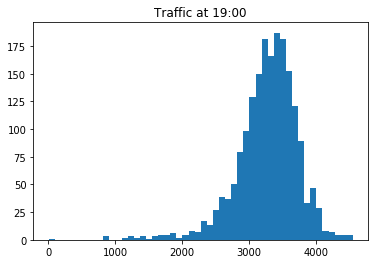

In [20]:
plt.hist(traffic_by_time[19], bins=50)
plt.title("Traffic at 19:00")

### Hierarchical model

In our hierarchical model, we will use singular months and the differences between multiple months to assess the differences between several months and their hyperparameters. This means that we will run our model together for all the 12 months on a certain hour but then assess the results separately and see how the means and deviations work.

$$\theta_j | y_j \sim Norm(\mu_j , \sigma^2_j)$$

### Separate model

In our separate model, we will use singular months to assess the differences between several months and their hyperparameters. This means that we will run our model separately for all the 12 months on a certain hour.

## Prior choices

// priorivalintojen perusteleminen tässä

Informative vai weakly informative?

Perustuu luultavasti aikasempaan visuaaliseen tulkintaan noista jakaumista


## The model and training

Next off we are going to introduce our model and train it using STAN.

This model is a modified version of "Comparison of k groups with common variance (ANOVA)" accessed on 06/12/19 from http://avehtari.github.io/BDA_R_demos/demos_rstan/rstan_demo.html#8_comparison_of_k_groups_with_hierarchical_models

In [21]:
separate_model = """
data {
    int<lower=0> N; // number of data points
    int<lower=0> K; // number of groups
    int<lower=1, upper=K> x[N]; // groups indicator
    vector[N] y; // data
}

parameters {
    vector[K] mu; // mean per group
    vector<lower=0>[K] sigma; // std per group
}
model {
    y ~ normal(mu[x], sigma[x]);
}

generated quantities {
    vector[K] ypred;
    vector[N] log_lik;
    for (k in 1:K)
        ypred[k] = normal_rng(mu[k], sigma[k]);
    for (n in 1:N)
        log_lik[n] = normal_lpdf(y[n] | mu[x[n]], sigma[x[n]]);
}

"""

In [22]:
separate_stan = pystan.StanModel(model_code=separate_model)

traffic_data = traffic_by_month

K = len(traffic_data)
y = [datapoint for month in traffic_data for datapoint in month]
x = [i+1 for i in range(K) for j in range(len(traffic_data[0]))]
N = len(x)

separate_data = {
    'N': N,
    'K': K,
    'y': y,
    'x': x
}

separate_fit = separate_stan.sampling(data=separate_data)

separate_samples = separate_fit.extract(permuted=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e63661ba423525650ca5a66342109c35 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


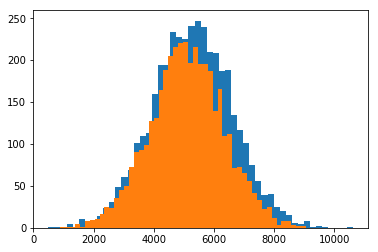

In [23]:
# January
plt.hist(separate_samples['ypred'][:,10], bins=50);
plt.hist(separate_samples['ypred'][:,0], bins=50);

In [24]:
hierarchical_model = """
data {
    int<lower=0> N; // number of data points
    int<lower=0> K; // number of groups
    int<lower=1, upper=K> x[N]; // groups indicator
    vector[N] y; // data
}

parameters {
    real mu0; // prior mean per group
    real sigma0; // prior std per group
    
    vector<lower=0>[K] mu; // mean per group
    vector<lower=0>[K] sigma; // std per group
}
model {
    mu ~ normal(mu0, sigma0);
    y ~ normal(mu[x], sigma[x]);
}

generated quantities {
    vector[K] ypred;
    vector[N] log_lik;
    for (k in 1:K)
        ypred[k] = normal_rng(mu[k], sigma[k]);
    for (n in 1:N)
        log_lik[n]=normal_lpdf(y[n] | mu[x[n]], sigma[x[n]]);

}

"""

In [25]:
hierarchical_stan = pystan.StanModel(model_code=hierarchical_model)

traffic_data = traffic_by_month

K = len(traffic_data)
y = [datapoint for month in traffic_data for datapoint in month]
x = [i+1 for i in range(K) for j in range(len(traffic_data[0]))]
N = len(x)

hierarchical_data = {
    'N': N,
    'K': K,
    'y': y,
    'x': x
}

hierarchical_fit = hierarchical_stan.sampling(data=hierarchical_data)

hierarchical_samples = hierarchical_fit.extract(permuted=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_21a08c3205225b67150cc65f4461b689 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


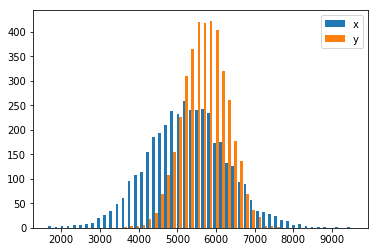

In [26]:
# January
x = hierarchical_samples['ypred'][:,6]
y = hierarchical_samples['ypred'][:,2]

plt.hist([x, y], bins=50, label=['x', 'y'], rwidth=0.9)
plt.legend(loc='upper right')
#plt.figure(figsize=(10,20))
plt.show()

In [28]:
hierarchical_inference_data = az.from_pystan(
    posterior=hierarchical_fit,
    #posterior_predictive='ypred7',
    observed_data=['y'],
    log_likelihood='log_lik'
)

az.loo(hierarchical_inference_data, pointwise=True, scale="log")

/home/otso/.local/lib/python3.6/site-packages/arviz/stats/stats.py:482: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 1212 log-likelihood matrix

         Estimate       SE
elpd_loo -9739.14    54.66
p_loo       56.08        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1203   99.3%
 (0.5, 0.7]   (ok)          4    0.3%
   (0.7, 1]   (bad)         5    0.4%
   (1, Inf)   (very bad)    0    0.0%

In [29]:
separate_inference_data = az.from_pystan(
    posterior=separate_fit,
    #posterior_predictive='ypred7',
    observed_data=['y'],
    log_likelihood='log_lik'
)

az.loo(separate_inference_data, pointwise=True, scale="log")

/home/otso/.local/lib/python3.6/site-packages/arviz/stats/stats.py:482: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 1212 log-likelihood matrix

         Estimate       SE
elpd_loo -9740.58    54.87
p_loo       58.48        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1206   99.5%
 (0.5, 0.7]   (ok)          2    0.2%
   (0.7, 1]   (bad)         4    0.3%
   (1, Inf)   (very bad)    0    0.0%